# Train Model: Water vs. Wildland

This model requires pytorch and fast.ai to run. The images downloaded from the Data Build script are used as inputs for this script. A directory containing the labeled imagery is needed as the input. Within the directory are all the Firebreak image tiles sorted into their named folders.


In [1]:
from fastai.vision.all import *
import pathlib

In [2]:
tileDir = r'D:\Projects\WORKING\ML\imagery\training_water_wildland'
data_dir = pathlib.Path(tileDir)
data_dir

Path('D:/Projects/WORKING/ML/imagery/training_water_wildland')

Use the fastai function `get_image_files()` to retreive all the image files in one folder. Then, get a count of all image files in data directory. This is just to make sure the data is all where it needs to be.

In [3]:
files = get_image_files(data_dir/"water")
len(files)

903

In [4]:
files = get_image_files(data_dir/"wildland")
len(files)

1724

In [5]:
files = get_image_files(data_dir)
len(files)

2627

## Define Labels

Define the labels for the classifier. The labels are taken from the parent folder names in the data_dir location. The `label_func()` function is passed into the data loader as an input variable.

In [6]:
def label_func(x): return x.parent.name

## Data Loader

Define a dataloader for images using the `from_path_func()` loader. The image can be resized by changing the `item_tfms=Resize()` option. The default was 224px for the GCOE tiger team, but I do not think the Firebreak tiles will need to be resized.  


In [7]:
print('Path to JPG directory:\n\t{0}'.format(data_dir))

# Testing dataloaders
#dls = ImageDataLoaders.from_name_func(data_dir, files, get_labels, item_tfms=Resize(224)) #from intro tutorial - Works
#dls = ImageDataLoaders.from_name_func(data_dir, files, get_labels, valid_pct=0.2, seed=42, bs=64) #from mashup Jawsem and my code - Works
dls = ImageDataLoaders.from_path_func(data_dir, files, label_func, item_tfms=Resize(224), valid_pct=0.2, seed=42, bs=64)


Path to JPG directory:
	D:\Projects\WORKING\ML\imagery\training_water_wildland


#### Label List

Check the number of categories found in the data loader and check the label spelling is right. Just make sure it all looks good.

In [8]:
print('There are {0} categories:'.format(dls.c))

dls.vocab

There are 2 categories:


['water', 'wildland']

#### JPG Display

Display some sample images from the data loader to check the labels and augmentations if there are any.

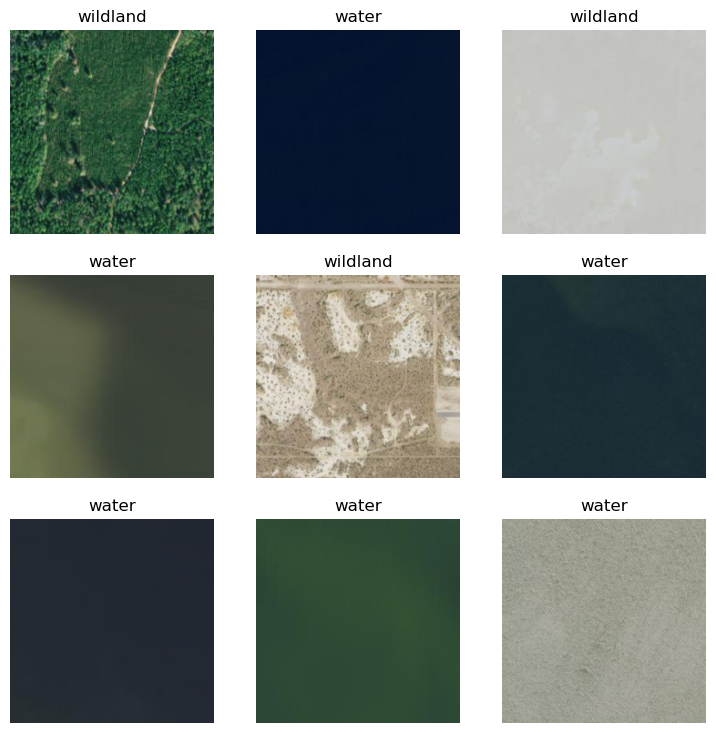

In [9]:
dls.show_batch()

## Create Learner
### Training: ResNet34

There were two pre-trained models that we used in the GCOE tiger team: [ResNet34](https://www.kaggle.com/code/pinkquek/fast-ai-with-resnet34-99-accuracy) and [ResNet18](https://www.kaggle.com/code/tcapelle/resnet-18-with-fastai/notebook) 

I do not know which is more appropriate for this project. There were no satellite images used to train either of these models as far as I know. Jawsem used ResNet18 and the tutrials on fast.ai used ResNet34.

This code is take from the fast.ai tutorial [here](https://docs.fast.ai/tutorial.vision.html) for a simple two class model.

In [10]:
learn = vision_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

C:\Users\andolson\AppData\Local\ESRI\conda\envs\ArcAI\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\andolson\AppData\Local\ESRI\conda\envs\ArcAI\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.426132,0.101168,0.039062,02:17


epoch,train_loss,valid_loss,error_rate,time
0,0.111788,0.075755,0.027344,02:57


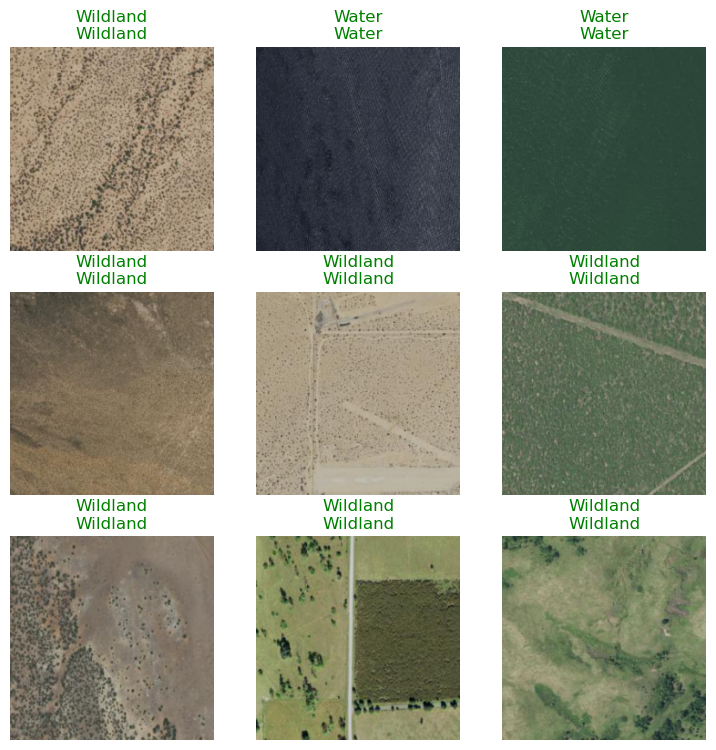

In [11]:
learn.show_results()

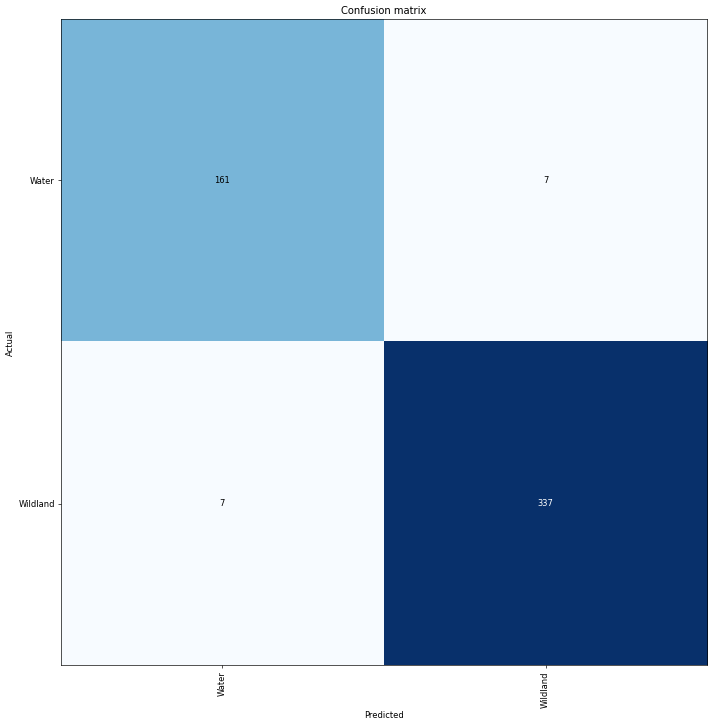

In [12]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

### Predict Image with ResNet34

Use the model to make a prediction by calling `predict()` and naming an image in the input data sample.

In [13]:
learn.predict(files[0])

('Water', tensor(0), tensor([0.9953, 0.0047]))

In [17]:
files[0]

Path('D:/Projects/WORKING/ML/imagery/Water_Wildland/Water/1100.jpg')

Use the model to make a prediction with an image that is not from the input data sample. Use an image from another class to test the result, like Agriculture or High Density Residential. 

In [18]:
imagesDir  = r'D:\Projects\WORKING\ML\imagery\firebreak_labels_sorted'
data_dir = pathlib.Path(imagesDir)
data_dir

Path('D:/Projects/WORKING/ML/imagery/firebreak_labels_sorted')

In [19]:
images = get_image_files(data_dir)
len(images)

9670

In [20]:
images[0]

Path('D:/Projects/WORKING/ML/imagery/firebreak_labels_sorted/Agriculture/101.jpg')

In [21]:
learn.predict(images[0])

('Water', tensor(0), tensor([9.9997e-01, 2.5330e-05]))

In [22]:
images[2000]

Path('D:/Projects/WORKING/ML/imagery/firebreak_labels_sorted/High Density Residential/6827.jpg')

In [23]:
learn.predict(images[2000])

('Wildland', tensor(1), tensor([0.0839, 0.9161]))

### Training: ResNet18

This learner is taken straight from Jawsem's code for the GCOE tiger team project. The pre-train model is a different version that what is in the fastai tutorials. ResNet-18 is a convolutional neural network that is 18 layers deep. The pretrained network can classify images into 1000 object categories, such as keyboard, mouse, pencil, and many animals. As a result, the network has learned rich feature representations for a wide range of images. The network has an image input size of 224-by-224.

In [10]:
#learn = cnn_learner(dls,resnet18, metrics=[error_rate,accuracy],loss_func=LabelSmoothingCrossEntropy(),path='.models').to_fp16()
learn = vision_learner(dls,resnet18, metrics=[error_rate,accuracy],loss_func=LabelSmoothingCrossEntropy(),path='.models').to_fp16()

C:\Users\andolson\AppData\Local\ESRI\conda\envs\ArcML\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\andolson\AppData\Local\ESRI\conda\envs\ArcML\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


#### Find best learning rate for the model

At every training step (iteration) of the network, the results calculated in the forward propagation step are compared with the ground truth (actual) values to calculate the error or loss score. Then, that error is backpropagated in the backpropagation step to adjust the initial values of the weights and biases so that the error is minimized in the next steps of training. We continue training until we get the minimum error.

https://towardsdatascience.com/how-to-choose-the-optimal-learning-rate-for-neural-networks-362111c5c783

1
steepest point: 6.31e-05


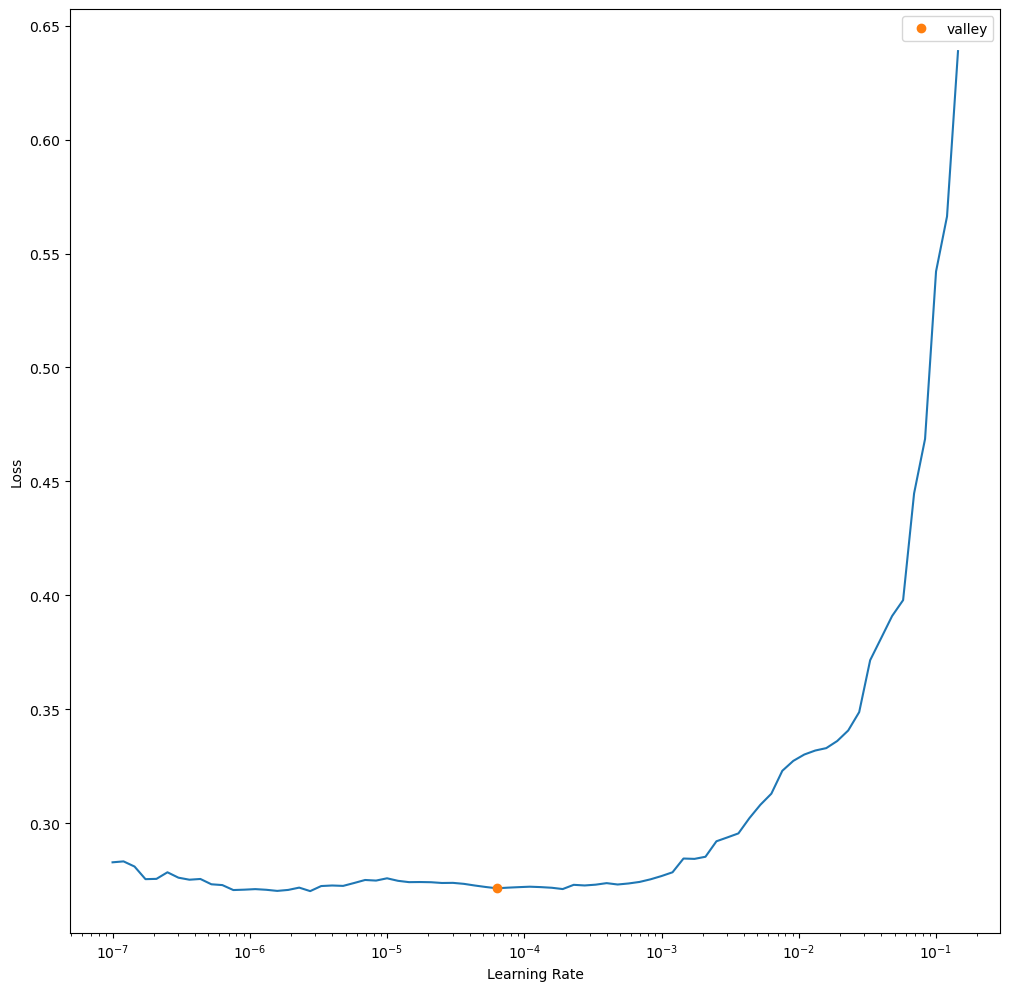

In [24]:
lr_steep = learn.lr_find()
print(len(lr_steep))
lr_steep = lr_steep[0]
print(f"steepest point: {lr_steep:.2e}")


In [12]:
callbacks = [SaveModelCallback(fname='fire_break_model'),CSVLogger(append=True)]
learn.fine_tune(10,freeze_epochs=3,base_lr=lr_steep,cbs=callbacks)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.839390,0.500351,0.095238,0.904762,02:03
1,0.631040,0.387519,0.049524,0.950476,01:59
2,0.520928,0.334445,0.040000,0.960000,01:54


Better model found at epoch 0 with valid_loss value: 0.5003507137298584.
Better model found at epoch 1 with valid_loss value: 0.38751867413520813.
Better model found at epoch 2 with valid_loss value: 0.3344452977180481.


epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.417195,0.362348,0.038095,0.961905,02:25
1,0.387610,0.341117,0.032381,0.967619,02:27
2,0.362922,0.317878,0.034286,0.965714,02:25
3,0.342570,0.305305,0.034286,0.965714,02:25
4,0.323424,0.290821,0.034286,0.965714,02:25
5,0.309495,0.278002,0.032381,0.967619,02:25
6,0.294839,0.284570,0.036190,0.963810,02:24
7,0.283363,0.275957,0.036190,0.963810,02:24
8,0.277095,0.278097,0.038095,0.961905,02:23
9,0.276617,0.277955,0.036190,0.963810,02:24


Better model found at epoch 0 with valid_loss value: 0.36234769225120544.
Better model found at epoch 1 with valid_loss value: 0.3411170542240143.
Better model found at epoch 2 with valid_loss value: 0.31787773966789246.
Better model found at epoch 3 with valid_loss value: 0.3053053021430969.
Better model found at epoch 4 with valid_loss value: 0.29082074761390686.
Better model found at epoch 5 with valid_loss value: 0.2780022621154785.
Better model found at epoch 7 with valid_loss value: 0.2759573459625244.


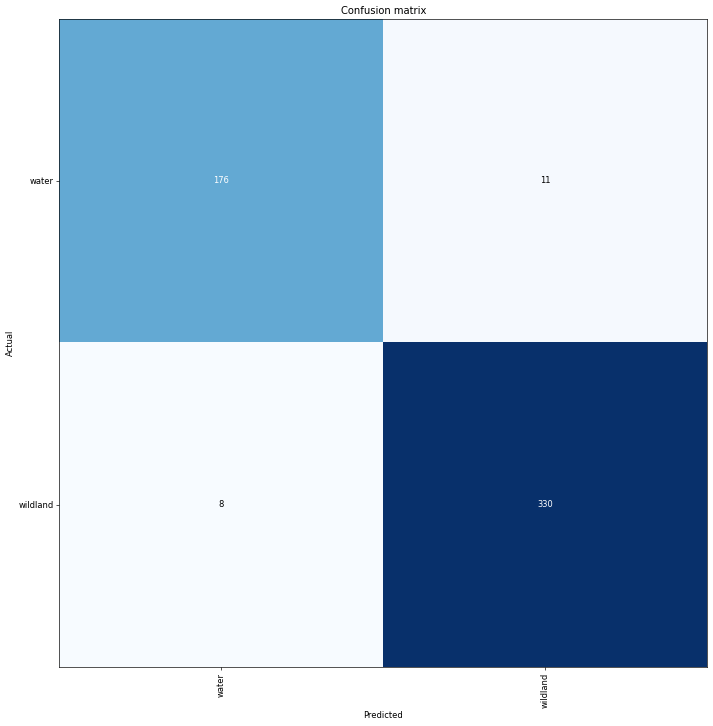

In [13]:
from matplotlib import rcParams
rcParams['figure.figsize'] = (12, 12)
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [14]:
interp.print_classification_report()

              precision    recall  f1-score   support

       water       0.96      0.94      0.95       187
    wildland       0.97      0.98      0.97       338

    accuracy                           0.96       525
   macro avg       0.96      0.96      0.96       525
weighted avg       0.96      0.96      0.96       525



In [15]:
learn.export('wildlandwater_resnet18.pkl')
learn.export(r'D:\Projects\Github\SAGIS-Risk\1 Natural Hazards\1 Wildfire\Firebreak_Enhancement\dev\fastai_models\wildlandwater_resnet18.pkl')

### Predict Image with ResNet18

Use the model to make a prediction by calling `predict()` and naming an image in the input data sample.

Use the model to make a prediction with an image that is not from the input data sample. Use an image from another class to test the result, like Agriculture or High Density Residential. 

In [16]:
imagesDir  = r'D:\Projects\WORKING\ML\imagery\CO_Water_Wildland'
data_dir   = pathlib.Path(imagesDir)
data_dir

Path('D:/Projects/WORKING/ML/imagery/CO_Water_Wildland')

In [17]:
files = get_image_files(data_dir/"wildland")
len(files)

861858

In [18]:
from datetime import datetime as dt
import csv
from pathlib import Path

In [20]:
cnt = 0

results = []

# Start a timer
startTime = dt.now()

while cnt < 1000:
    
    # Pull out image id
    image_name = files[cnt].stem   
    
    # Make the prediction
    pred_class, pred_idx, outputs = learn.predict(files[cnt])

    # Extract the probabilities for 'water' and 'wildland' classes
    water_prob = outputs[0].item()
    wildland_prob = outputs[1].item()

    # Append the results to the list
    results.append([image_name, pred_class, water_prob, wildland_prob])
    
    cnt += 1

endTime = dt.now()-startTime
endTime

C:\Users\andolson\AppData\Local\ESRI\conda\envs\ArcML\lib\site-packages\torch\amp\autocast_mode.py:204: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')
C:\Users\andolson\AppData\Local\ESRI\conda\envs\ArcML\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


datetime.timedelta(seconds=85, microseconds=165023)

In [21]:
# Start a timer
startTime = dt.now()

# Define the path to the CSV file
csv_path = r'D:\Projects\WORKING\ML\Results_Table.csv'

# Write the results to the CSV file
with open(csv_path, "w", newline="") as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(["Image Name", "Label", "Water Probability", "Wildland Probability"])  # Write the header
    writer.writerows(results)  # Write the data rows

endTime = dt.now()-startTime
endTime

datetime.timedelta(microseconds=7806)